In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from scipy import stats
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
import xgboost

In [2]:
# 以下代码从全局设置字体为Arial Unicode MS，解决显示中文问题
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# 解决中文字体下坐标轴负数的负号显示问题
plt.rcParams['axes.unicode_minus'] = False

In [3]:
#运行此单元之前应该将下载的数据放在根目录下
data = pd.read_csv('winequality-red.csv')

In [4]:
#数据中没有nan，不需要删除，另外而且没有类别数据
data.isna().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [5]:
#可以看到各特征的分布性质
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


葡萄酒的quality得分在3-8之间，平均分为5.64，中位数为6，说明该批葡萄酒的整体质量处于中等水平

接下来对变量进行正态性检验：

In [6]:
dagostino_test = stats.normaltest(data)
print("D'Agostino-Pearson检验结果")
print("统计量：")
dagostino_test_df = pd.DataFrame(zip(dagostino_test.statistic, dagostino_test.pvalue), columns=['统计量', 'p-value'], index=data.columns)
dagostino_test_df

D'Agostino-Pearson检验结果
统计量：


,统计量,p-value
fixed acidity,224.530878,1.752828e-49
volatile acidity,143.419344,7.192589e-32
citric acid,152.039215,9.662822e-34
residual sugar,1520.323970,0.000000e+00
chlorides,1783.105923,0.000000e+00
free sulfur dioxide,342.259148,4.779365e-75
total sulfur dioxide,487.427256,1.433891e-106
density,30.707750,2.147320e-07
pH,33.684697,4.846865e-08
sulphates,906.894448,1.175907e-197


从结果来看，所有变量均不符合正态分布

接下来对偏度、峰度、极值进行分析：

In [7]:
# 偏度
print("偏度\n", data.skew().sort_values(ascending=False))
# 峰度
print("峰度\n", data.kurt().sort_values(ascending=False))
# 极值 这里可以强调一下我们注意细节，没有直接最大值最小值之差，还作比并添加1e-10避免除0
print("极值比\n", ((data.max() - data.min()) / (data.min() + 1e-10)).sort_values(ascending=False))

偏度
 chlorides               5.680347
residual sugar          4.540655
sulphates               2.428672
total sulfur dioxide    1.515531
free sulfur dioxide     1.250567
fixed acidity           0.982751
alcohol                 0.860829
volatile acidity        0.671593
citric acid             0.318337
quality                 0.217802
pH                      0.193683
density                 0.071288
dtype: float64
峰度
 chlorides               41.715787
residual sugar          28.617595
sulphates               11.720251
total sulfur dioxide     3.809824
free sulfur dioxide      2.023562
volatile acidity         1.225542
fixed acidity            1.132143
density                  0.934079
pH                       0.806943
quality                  0.296708
alcohol                  0.200029
citric acid             -0.788998
dtype: float64
极值比
 citric acid             1.000000e+10
free sulfur dioxide     7.100000e+01
chlorides               4.991667e+01
total sulfur dioxide    4.716667e+01
resid

偏度衡量随机变量概率分布的不对称性，是相对于平均值不对称程度的度量，通过对偏度系数的测量，我们能够判定数据分布的不对称程度以及方向。偏度的定义为样本的三阶标准化矩：

$$Skew(X) = E[(\frac{X-\mu}{\sigma})^3] = \frac{E[(X-\mu)^3]}{(E[(X-\mu)^2])^{\frac{3}{2}}}$$


偏度的衡量是相对于正态分布来说，正态分布的偏度为0，即若数据分布是对称的，偏度为0。若偏度大于0，则分布右偏，即分布有一条长尾在右；若偏度小于0，则分布为左偏，即分布有一条长尾在左，同时偏度的绝对值越大，说明分布的偏移程度越严重。(注意数据分布的左偏或右偏，指的是数值拖尾的方向，而不是峰的位置。)

峰度衡量了数据分布的陡峭程度，通过对峰度系数的测量，可以判定数据相对于正态分布而言是更陡峭还是更平缓。比如正态分布的峰度为0，均匀分布的峰度为-1.2（平缓），指数分布的峰度为6（陡峭）。

峰度的定义如下：

$$\gamma_2 = \frac{\mu_4}{\delta_4} - 3$$


从以上数据可知：
* 其中右偏最严重的是chlorides(氯化物)，它的偏度达到了5.68，其次分别是residual sugar(剩余糖分)、sulphates(硫酸盐)等。
* 从峰度可知，chlorides(氯化物)、residual sugar(剩余糖分)、sulphates(硫酸盐)峰值较高，数据较为集中；而citric acid(柠檬酸)峰值为负数，数据较为分散。
* 从极值数据可知，citric acid （柠檬酸）极值比最大，其次是free sulfur dioxide（游离二氧化硫）、chlorides（氯化物）、total sulfur dioxide（总二氧化硫），结合下文直方图、箱线图可以知道这几项存在一些远大于均值的异常值。

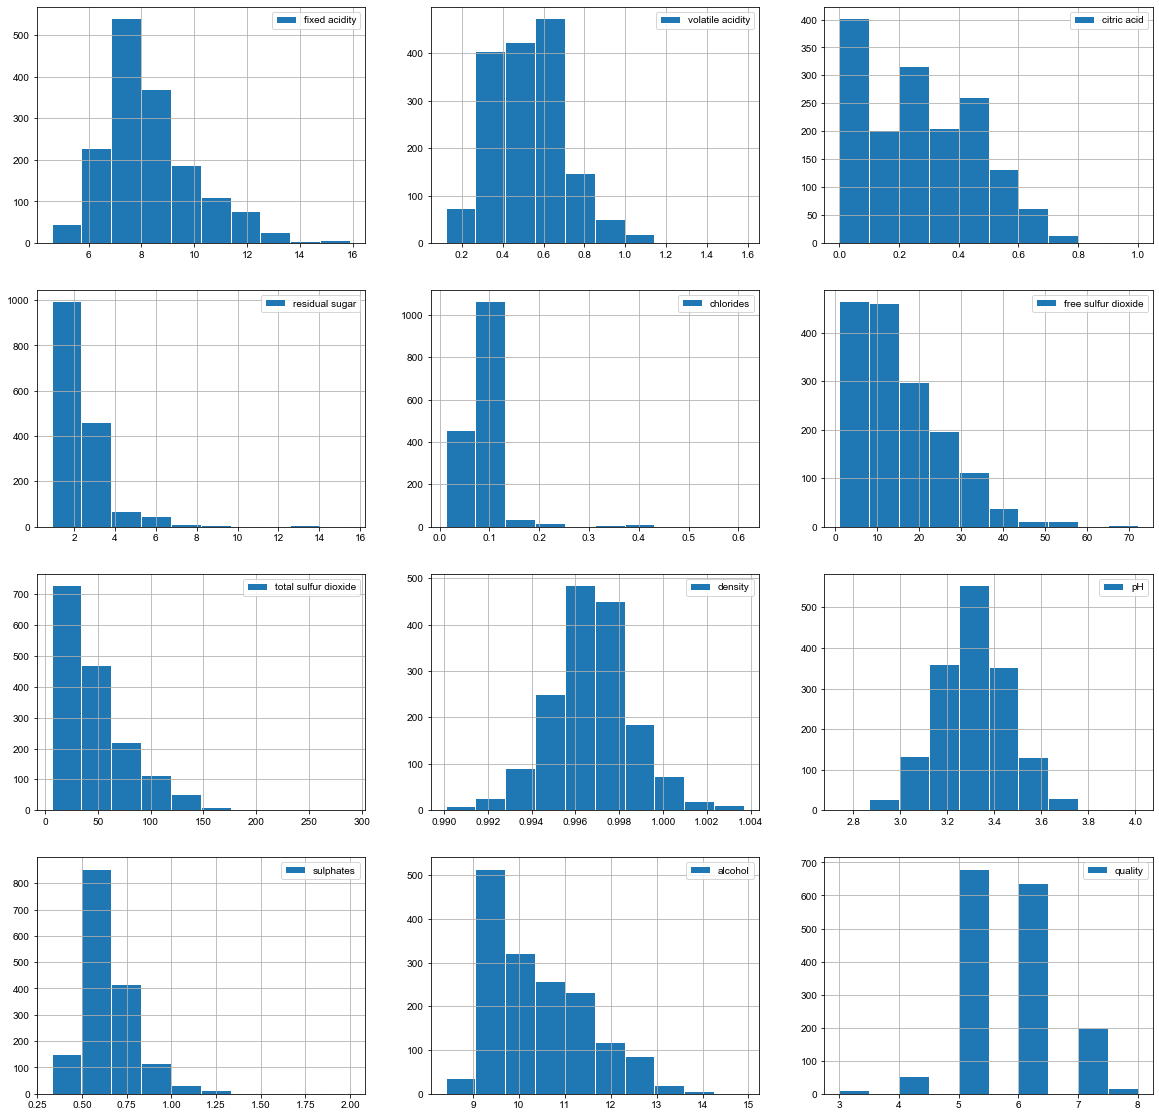

In [8]:
#histplot一下特征和标签
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 20))

for index, column in enumerate(data.columns):
    ax = axes.flatten()[index]
    ax.hist(data[column], label = column, edgecolor='white')
    ax.legend()
    ax.grid()

可以看到'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'这些列的分布比较偏，而其他特征相对接近正态分布

In [9]:
#直接count一下，发现是很不均衡的
print('标签为3的个数:', (data['quality'] == 3).sum())
print('标签为4的个数:', (data['quality'] == 4).sum())
print('标签为5的个数:', (data['quality'] == 5).sum())
print('标签为6的个数:', (data['quality'] == 6).sum())
print('标签为7的个数:', (data['quality'] == 7).sum())
print('标签为8的个数:', (data['quality'] == 8).sum())

标签为3的个数: 10
标签为4的个数: 53
标签为5的个数: 681
标签为6的个数: 638
标签为7的个数: 199
标签为8的个数: 18


可以看到pH值有较多离群值

In [ ]:
# data['alcohol'].plot.box()

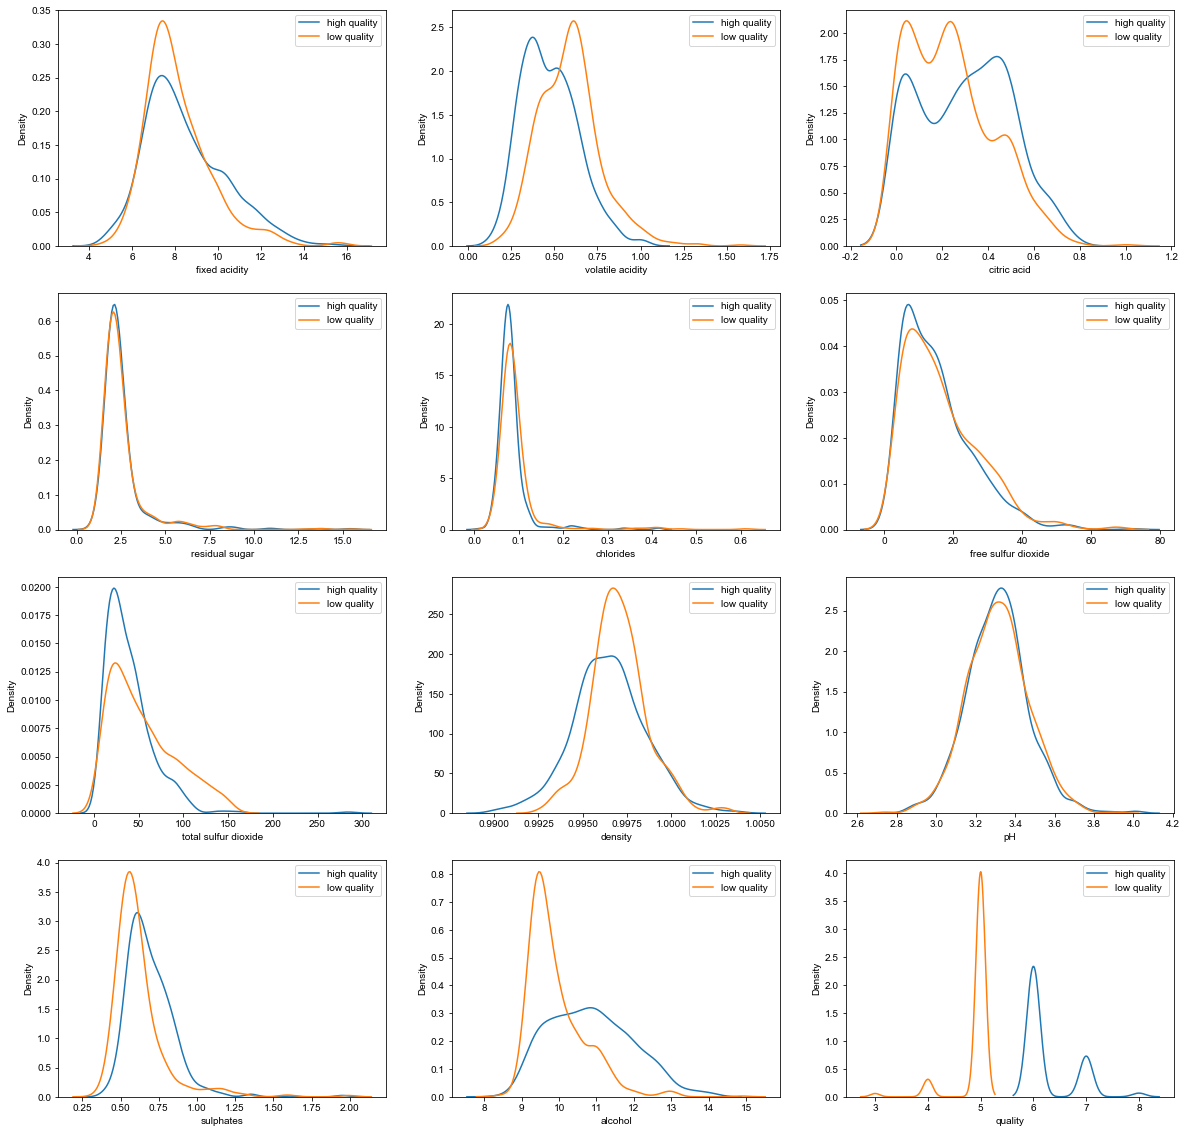

In [10]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 20))

for index, col in enumerate(data.columns):
    ax = axes.flatten()[index]
    sn.kdeplot(data[col][data['quality']>=6], ax=ax)
    sn.kdeplot(data[col][data['quality']<6], ax=ax)
    ax.legend(['high quality', 'low quality'])

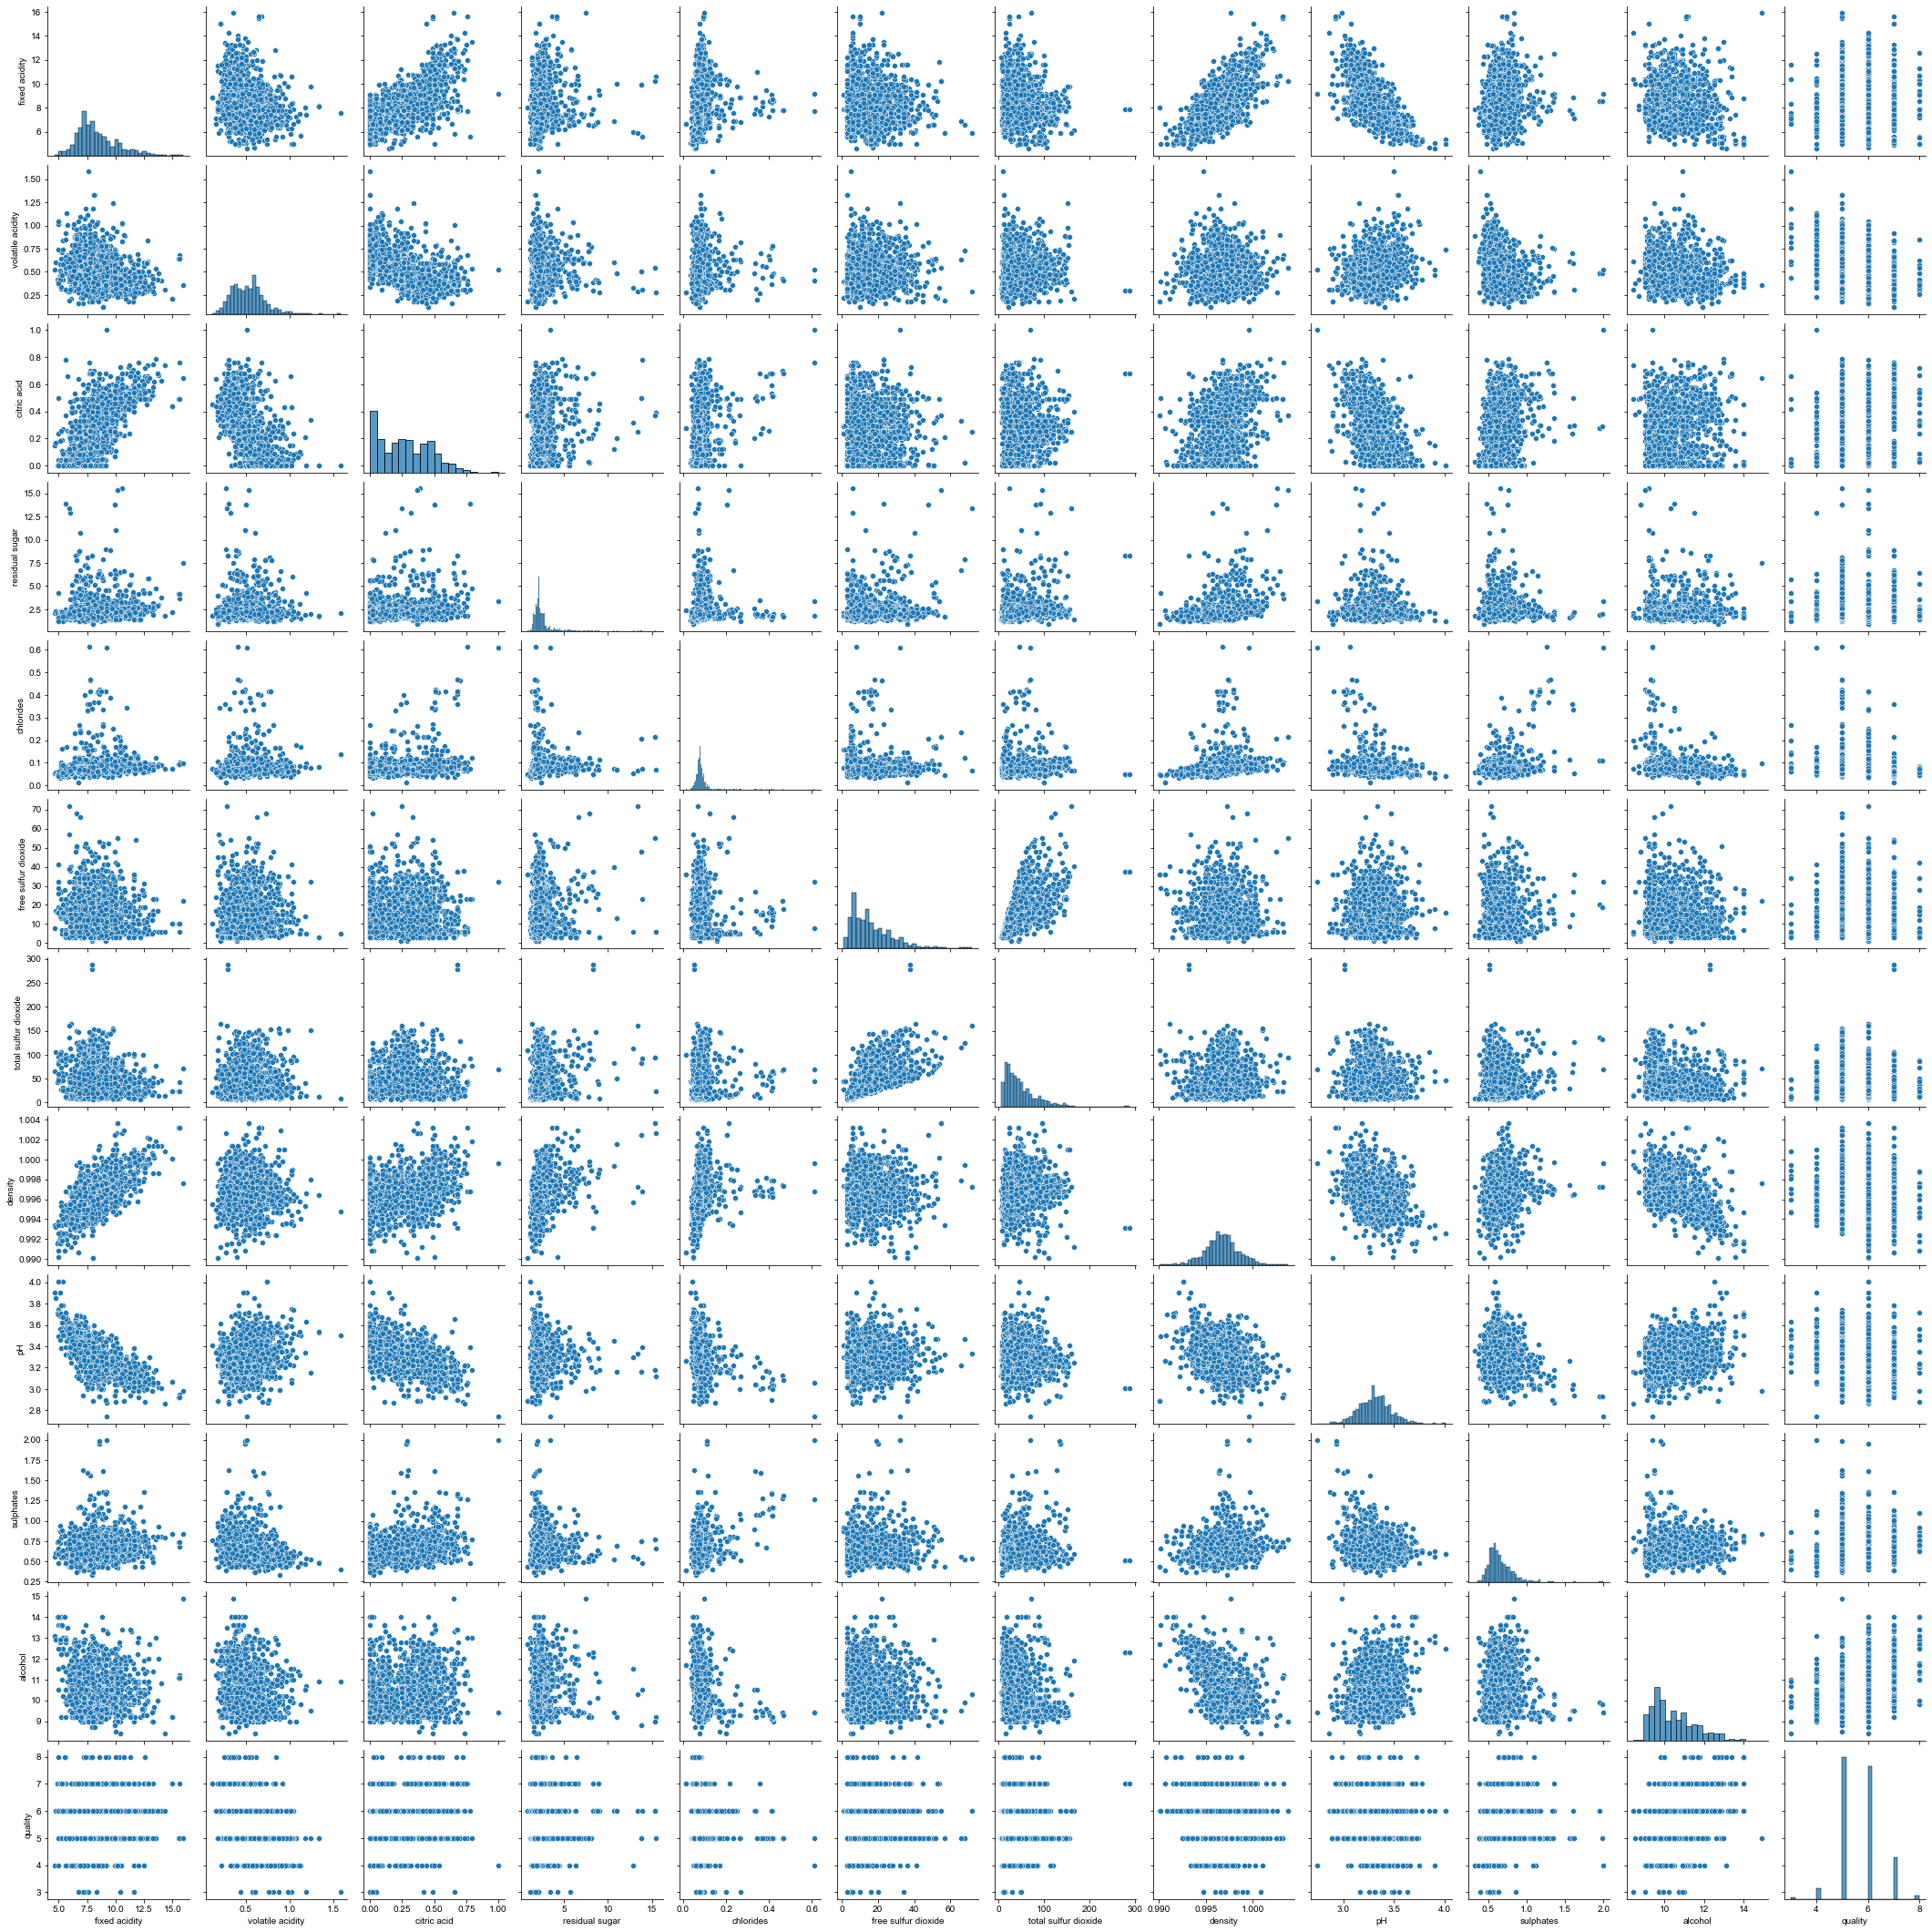

In [11]:
sn.pairplot(data)

接下来对相关性进行分析

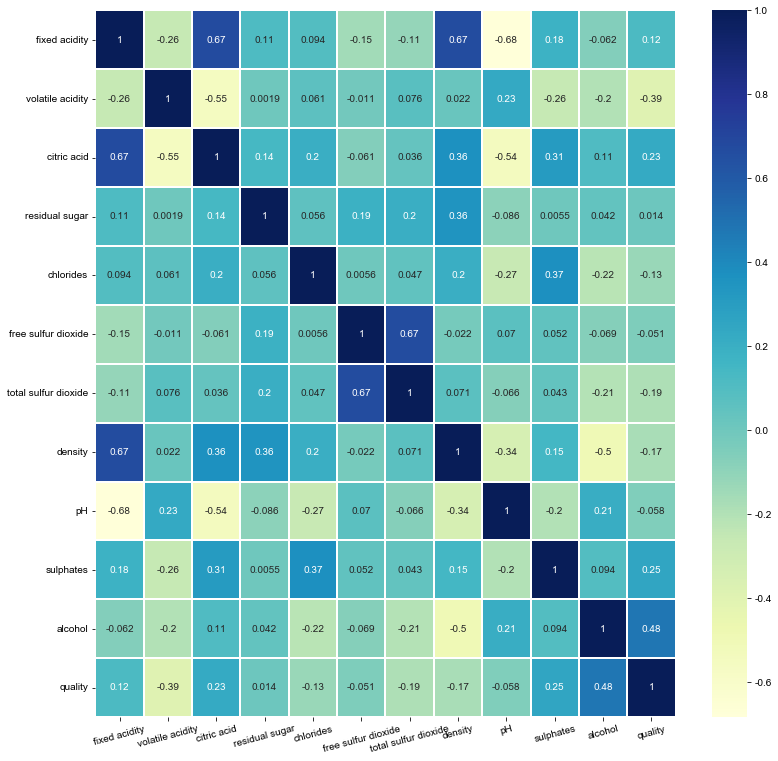

In [12]:
# 使用coolwarm颜色映射来提高热力图可读性
plt.figure(figsize=(13, 13))
corr_data = data.corr()
sn.heatmap(corr_data, linewidths=0.1, cmap='YlGnBu', annot=True)
plt.xticks(rotation=15)
plt.show()

* 从热力图和协方差矩阵来看，volatile acidity和quality弱负相关，和alcohol中等强度相关，品质和酒精度有一定正相关，以及和Volatile acidity有一定负相关，但是都不明显
* 另外可以看到Fixed acidity和Citric acid有比较高的相关性，这点可能是因为它们都是水果（尤其是柑橘）中的所含酸，所以可能同属于某种水果添加
* 以下是引用，建模时可以考虑drop掉二者其中一个
    * https://en.wikipedia.org/wiki/Tartaric_acid
    * https://en.wikipedia.org/wiki/Citric_acid
* 还可以看到fixed acidity和density呈正相关，和pH呈负相关；volatile acidity和citric acid负相关；citric acid和pH负相关；total sulfur dioxide和free sulfur dioxide正相关；alcohol和density负相关

In [13]:
data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


接下来绘制累积方差贡献图，选择合适的主成分个数

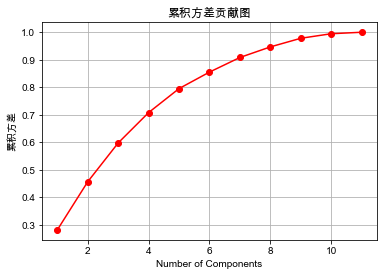

In [14]:
X = data.drop(['quality'], axis=1)
sc = StandardScaler()
X = sc.fit_transform(X)

# 执行主成分分析
pca = PCA(random_state=0)
pca.fit(X)

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()
plt.xlabel('Number of Components')
plt.ylabel('累积方差')
plt.title('累积方差贡献图')
plt.show()

In [15]:
sum(pca.explained_variance_ratio_[:5])

0.7952827473610353

前5个主成分的方差贡献率可达80%，因此取前5个即可

In [16]:
# 执行主成分分析
pca = PCA(n_components=5, random_state=0)  # 设置主成分个数为5
pca.fit(X)

# 计算主成分得分
data_scores = pca.transform(X)

# 创建包含主成分得分的DataFrame
data_scores_df = pd.DataFrame(data_scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# 将得分与原始数据合并
result = pd.concat([data, data_scores_df], axis=1)

接下来计算因子负荷量，查看各个主成分和原始变量的关系：

In [17]:
sqrt_lambda_k = np.tile(np.sqrt(pca.explained_variance_), (11, 1)).T  # X轴不复制 (5, 11)
alpha_ik = pca.components_  # (5, 11)

sqrt_sigma_ii = np.tile(np.sqrt(X.var()), (5, 1))  # (5, 11)
# element-wise计算相关系数也即因子负荷量
rou_Yk_Xi = alpha_ik * sqrt_lambda_k / sqrt_sigma_ii  # (5, 11)

loadings_df = pd.DataFrame(rou_Yk_Xi.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=data.columns[:11])
loadings_df

,PC1,PC2,PC3,PC4,PC5
fixed acidity,0.861676,-0.153401,-0.153584,-0.252995,-0.080940
volatile acidity,-0.420144,0.381660,-0.560472,0.086999,0.214303
citric acid,0.816449,-0.210718,0.296760,-0.087504,-0.057386
residual sugar,0.257293,0.377703,0.126158,-0.410748,0.717312
chlorides,0.373763,0.205526,-0.115360,0.734022,0.241507
free sulfur dioxide,-0.063673,0.712936,0.534103,-0.047971,-0.155928
total sulfur dioxide,0.041515,0.790565,0.401599,-0.038098,-0.217958
density,0.696211,0.324251,-0.422097,-0.192266,0.153894
pH,-0.772227,0.009316,0.071868,-0.004173,0.262110
sulphates,0.427781,-0.052133,0.348501,0.606958,0.221384


从结果来看：
* fixed acidity、citric acid与PC1有极强的正相关性，pH与PC1有强负相关性
* free sulfur dioxide、total sulfur dioxide与PC2有强正相关性
* free sulfur dioxide、alcohol与PC3有中等程度正相关性，volatile acidity与PC3有中等程度负相关性
* chlorides、sulphates与PC4有强正相性
* residual sugar与PC5有强正相关性

获得主成分得分之后，开始训练逻辑回归、决策树、GBDT模型

In [18]:
# 构造标签，小于6分的设置为0，大于等于6分的设置为1
reviews = []
for i in data['quality']:
    if i < 6:
        reviews.append(0)
    else:
        reviews.append(1)
data['new_y'] = reviews

In [19]:
# 这里我们使用了PCA，如果不使用PCA，把下面一行代码注释掉，把X_new = X取消注释即可
x_new = result[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]
# x_new = X
test_ratio = 0.25
new_X_train, new_X_test, new_y_train, new_y_test = sklearn.model_selection.train_test_split(x_new, data['new_y'], test_size=test_ratio, random_state=0)

In [24]:
def draw_roc(model_name, y_test, y_pred):  # 注意y_pred应该是logits，而不是预测的label结果
    # 计算FPR, TPR和阈值
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

    # 计算AUC值
    auc_score = roc_auc_score(y_test, y_pred)

    # 绘制ROC曲线
    plt.plot(fpr, tpr, label='Auc: %0.4f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])  # 将y轴范围扩展一些，使得ROC曲线的最高点能够完整地展示出来
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC')
    plt.legend(loc="lower right")
    plt.show()

首先尝试逻辑回归模型

In [31]:
lr = LogisticRegression()
lr.fit(new_X_train, new_y_train)
lr_predict = lr.predict(new_X_test)
lr_logits = lr.predict_proba(new_X_test)[:, 1]  # 获取label为1的logits

In [32]:
lr_conf_matrix = confusion_matrix(new_y_test, lr_predict)
lr_acc_score = accuracy_score(new_y_test, lr_predict)
print('输出logistic regression的混淆矩阵如下：')
print(lr_conf_matrix)
print(f'FPR: {100 * lr_conf_matrix[0][1] / sum(lr_conf_matrix[0])}%')
print(f'FNR: {100 * lr_conf_matrix[1][0] / sum(lr_conf_matrix[1])}%')
print(f'正确率为{lr_acc_score * 100}%')

输出logistic regression的混淆矩阵如下：
[[135  50]
 [ 48 167]]
FPR: 27.027027027027028%
FNR: 22.325581395348838%
正确率为75.5%


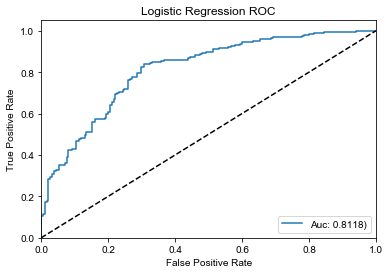

In [33]:
draw_roc('Logistic Regression', new_y_test.values, lr_logits)

构造决策树分类器，通过五折交叉验证调整参数

In [34]:
# 构建决策树分类器
search_clf = DecisionTreeClassifier(random_state=0)

# 定义参数搜索范围
param_grid = {'max_depth': [16, 17, 18, 19, 20], 
              'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [1, 2]}

# 使用GridSearchCV进行五折交叉验证，并对参数进行调优
# 需要考虑如何划分k折，因此也使用一个固定的随机数种子0
kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search_decision_tree = GridSearchCV(search_clf, param_grid=param_grid, cv=5)
grid_search_decision_tree.fit(new_X_train, new_y_train)

# 输出最佳参数组合
print("Best parameters: ", grid_search_decision_tree.best_params_)

# 在测试集上评估模型性能
print(f"Test set accuracy: {accuracy_score(new_y_test, grid_search_decision_tree.predict(new_X_test)) * 100}%")

Best parameters:  {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set accuracy: 71.25%


In [35]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(new_X_train, new_y_train)
dt_predict = dt.predict(new_X_test)

dt_conf_matrix = confusion_matrix(new_y_test, dt_predict)
dt_acc_score = accuracy_score(new_y_test, dt_predict)

print('输出决策树模型的混淆矩阵如下：')
print(dt_conf_matrix)
print(f'正确率为{dt_acc_score * 100}%')

输出决策树模型的混淆矩阵如下：
[[119  66]
 [ 49 166]]
正确率为71.25%


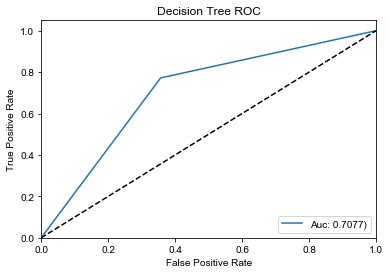

In [39]:
draw_roc('Decision Tree', new_y_test.values, grid_search_decision_tree.predict_proba(new_X_test)[:, 1])

接下来尝试GBDT模型

In [37]:
gdbt = GradientBoostingClassifier(random_state=0)
gdbt.fit(new_X_train, new_y_train)
gdbt_predict = gdbt.predict(new_X_test)

gbdt_conf_matrix = confusion_matrix(new_y_test, gdbt_predict)
gbdt_acc_score = accuracy_score(new_y_test, gdbt_predict)


print('输出GBDT模型的混淆矩阵如下：')
print(f'FPR: {100 * gbdt_conf_matrix[0][1] / sum(gbdt_conf_matrix[0])}%')
print(f'FNR: {100 * gbdt_conf_matrix[1][0] / sum(gbdt_conf_matrix[1])}%')
print(gbdt_conf_matrix)
print(f'正确率为{gbdt_acc_score * 100}%')

输出GBDT模型的混淆矩阵如下：
FPR: 31.35135135135135%
FNR: 19.069767441860463%
[[127  58]
 [ 41 174]]
正确率为75.25%


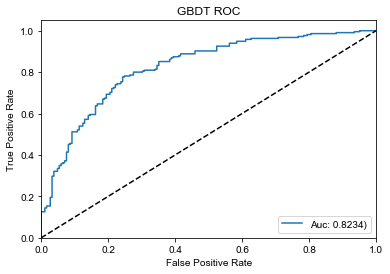

In [38]:
draw_roc('GBDT', new_y_test.values, gdbt.predict_proba(new_X_test)[:, 1])

In [40]:
model_params = {
        "learning_rate": 0.1,
        "colsample_bytree": 0.6,
        "subsample": 0.7,
        "max_depth": 70,
        "reg_alpha": 1,
        "reg_lambda": 1,
    }
xgb_x_train = xgboost.DMatrix(new_X_train, label=new_y_train)
xgb = xgboost.train(model_params, xgb_x_train, num_boost_round=120)
train_leaf = xgb.predict(xgb_x_train, pred_leaf=True)
xgb_x_test = xgboost.DMatrix(new_X_test)
test_leaf = xgb.predict(xgb_x_test, pred_leaf=True)
ohe = OneHotEncoder()
lr_feat = ohe.fit_transform(train_leaf)
linereg= LogisticRegression().fit(lr_feat, new_y_train)
lr_test = ohe.transform(test_leaf)
xgb_pred = linereg.predict(lr_test)
xgb_conf_matrix = confusion_matrix(new_y_test, xgb_pred)
xgb_acc_score = accuracy_score(new_y_test, xgb_pred)


print('输出XGBoost+lr模型的混淆矩阵如下：')
print(xgb_conf_matrix)
print(f'FPR: {100 * xgb_conf_matrix[0][1] / sum(xgb_conf_matrix[0])}%')
print(f'FNR: {100 * xgb_conf_matrix[1][0] / sum(xgb_conf_matrix[1])}%')
print(f'正确率为{xgb_acc_score * 100}%')

输出XGBoost+lr模型的混淆矩阵如下：
[[122  63]
 [ 26 189]]
FPR: 34.054054054054056%
FNR: 12.093023255813954%
正确率为77.75%


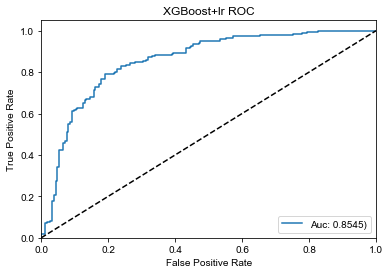

In [41]:
draw_roc('XGBoost+lr', new_y_test.values, linereg.predict_proba(lr_test)[:, 1])